In this lab today, we will run the kNN model to determine the best ‘k’ value in order to determine whether a wine is of high quality. 

Use the following features: ‘density’, ‘sulphates’, residual sugar’.

Please check 'k' values from 1 to 50 in order to determine the best value.

Below is starert code which obtains demo data from Amazon Web Services website:

In [145]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

In [106]:
import numpy as np
import pandas as pd
import pylab as pl
from sklearn.neighbors import KNeighborsClassifier

df = pd.read_csv("https://s3.amazonaws.com/demo-datasets/wine.csv")

test_idx = np.random.uniform(0, 1, len(df)) <= 0.7
train = df[test_idx==True]
test = df[test_idx==False]

features = ['density', 'sulphates', 'residual_sugar']


In [213]:
len(df)

6497

In [147]:
X = df[features]
y = df['high_quality']

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 77)

## Scaling the features

In [200]:
from sklearn.preprocessing import MinMaxScaler

In [201]:
X_train_scaled = MinMaxScaler().fit_transform(X_train)
X_test_scaled = MinMaxScaler().fit_transform(X_test)

In [202]:
len(y_train), len(y_test)

(4547, 1950)

In [203]:
y_train.sum(), y_test.sum()

(891.0, 386.0)

In [204]:
y_train.value_counts()

0.0    3656
1.0     891
Name: high_quality, dtype: int64

In [205]:
y_test.value_counts()

0.0    1564
1.0     386
Name: high_quality, dtype: int64

## Fitting training data to create KNN model

In [206]:
# Creating a list of k from 1:50

k = list(range(1,51))
leaf = list(range(10,31))

In [207]:
accuracy_list = []

for i in k:
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled, y_train)
    accuracy_list.append(knn.score(X_test_scaled, y_test))

In [208]:
%matplotlib inline
import matplotlib.pyplot as plt

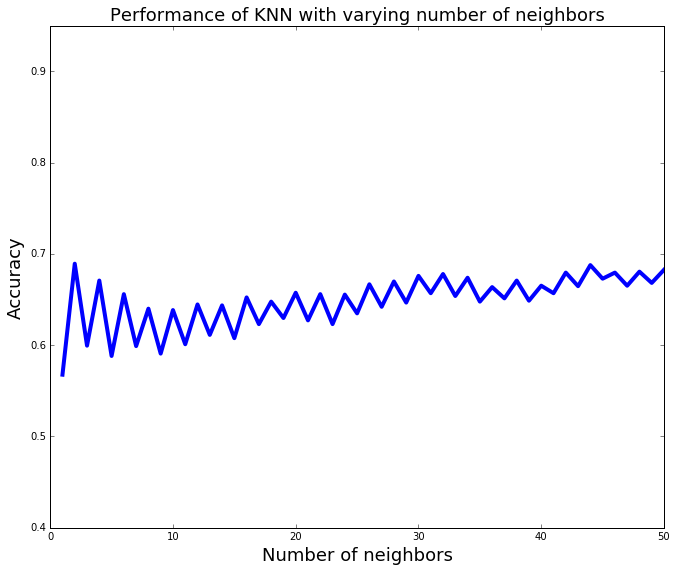

In [209]:
plt.figure(figsize=[11,9])
plt.plot(k, accuracy_list, linewidth=4)
#plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 50.0])
plt.ylim([0.4, 0.95])
plt.xlabel('Number of neighbors', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.title('Performance of KNN with varying number of neighbors', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [210]:
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=12, p=2,
           weights='uniform')

In [211]:
pred = knn.predict(X_test_scaled)

In [212]:
conmat = np.array(confusion_matrix(y_test, pred, knn.classes_))
confusion = pd.DataFrame(conmat, index=knn.classes_,
                            columns=knn.classes_)

print(confusion)
print classification_report(y_test,pred)


      0.0  1.0
0.0  1082  482
1.0   211  175
             precision    recall  f1-score   support

        0.0       0.84      0.69      0.76      1564
        1.0       0.27      0.45      0.34       386

avg / total       0.72      0.64      0.67      1950



## Gridsearch with KNN (Varying neighbors, leaf-size, weights)

In [130]:
from sklearn.grid_search import GridSearchCV

parameters = [{'n_neighbors': k, 'leaf_size': leaf, 'weights' : ['uniform', 'distance']}]
clf = GridSearchCV(KNeighborsClassifier(), parameters)
clf.fit(X_train_scaled, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50], 'weights': ['uniform', 'distance'], 'leaf_size': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [131]:
clf.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=48, p=2,
           weights='uniform')

In [132]:
clf.best_params_

{'leaf_size': 10, 'n_neighbors': 48, 'weights': 'uniform'}

In [133]:
clf.best_score_

0.7826935588809368

In [127]:
y_pred = clf.best_estimator_.predict(X_test_scaled)

In [134]:
conmat = np.array(confusion_matrix(y_test, y_pred, clf.best_estimator_.classes_))
confusion = pd.DataFrame(conmat, index=clf.best_estimator_.classes_,
                            columns=clf.best_estimator_.classes_)

print(confusion)
print classification_report(y_test,y_pred)


      0.0  1.0
0.0  1527    1
1.0   353    5
             precision    recall  f1-score   support

        0.0       0.81      1.00      0.90      1528
        1.0       0.83      0.01      0.03       358

avg / total       0.82      0.81      0.73      1886



## GridSearch with Logreg (varying Cs and regularization penalties)

In [102]:
c_list = np.arange(0.1,1,0.01)

In [103]:
parameters = [{'penalty': ['l1', 'l2'], "C": c_list}]
logreg = GridSearchCV(LogisticRegression(), parameters)
logreg.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'penalty': ['l1', 'l2'], 'C': array([ 0.1 ,  0.11, ...,  0.98,  0.99])}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [69]:
logreg.best_estimator_

LogisticRegression(C=0.10000000000000001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [70]:
logreg.best_score_

0.8093781855249745

In [72]:
y_pred2 = logreg.best_estimator_.predict(X_test)
y_score2 = logreg.decision_function(X_test)

      0.0  1.0
0.0  3632    0
1.0   903    0
             precision    recall  f1-score   support

        0.0       0.80      1.00      0.89      3632
        1.0       0.00      0.00      0.00       903

avg / total       0.64      0.80      0.71      4535



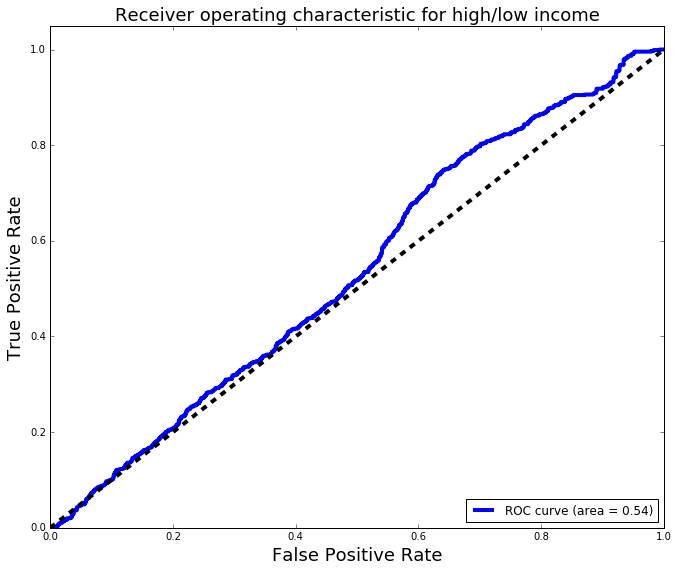

In [74]:
""" Check your performance so far."""

conmat = np.array(confusion_matrix(y_test, y_pred2, logreg.best_estimator_.classes_))
confusion = pd.DataFrame(conmat, index=logreg.best_estimator_.classes_,
                            columns=logreg.best_estimator_.classes_)

print(confusion)
print classification_report(y_test,y_pred2)
roc_auc_score(y_test, y_score2)

""" Plot AUC"""

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(y_test, y_score2)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for high/low income', fontsize=18)
plt.legend(loc="lower right")
plt.show()